In [67]:
from gp_sinkhorn.SDE_solver import solve_sde_RK
from gp_sinkhorn.utils import plot_trajectories_2
from gp_sinkhorn.MLE_drift import *
from gp_sinkhorn import MLE_drift
from gp_sinkhorn.arccos import ArcCos
from sklearn import datasets

import copy
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from pyro.contrib.gp.kernels import Exponential, Matern32, RBF, Brownian, Combination, Product, Sum
from celluloid import Camera
from IPython.display import HTML
from sklearn.datasets import make_swiss_roll

from plotting_utils import *

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from collections import defaultdict
from gp_sinkhorn.mem_utils import get_size_to_live_tensors, get_tensor_size, print_gpu_mem_usage

from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torchvision
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm

In [68]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024), verbose=False):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
        self.verbose = verbose
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            if self.verbose: print(f"enc1: {x.shape}")
                
            x = block(x)
            if self.verbose: print(f"enc2: {x.shape}")
                
            ftrs.append(x)
            x = self.pool(x)
            if self.verbose: print(f"enc3: {x.shape}")
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64), verbose=False):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        self.verbose = verbose
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            if self.verbose: print(f"dec1: {x.shape}")
                
            x        = self.upconvs[i](x)
            if self.verbose: print(f"dec2: {x.shape}")
            
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            if self.verbose: print(f"dec3: {x.shape}")            
            
            x        = self.upconvs[i](x)
            if self.verbose: print(f"dec4: {x.shape}")            
            
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            if self.verbose: print(f"dec5: {x.shape}")            
         
            x        = self.dec_blocks[i](x)
            if self.verbose: print(f"dec6: {x.shape}")   
                
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), 
                 dec_chs=(1024, 512, 256, 128, 64), num_class=1, 
                 retain_dim=False, out_sz=(28, 28),
                 verbose=False):
        super().__init__()
        self.encoder     = Encoder(enc_chs, verbose=verbose)
        self.decoder     = Decoder(dec_chs, verbose=verbose)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz = out_sz
        self.verbose = verbose


    def forward(self, x):
        if self.verbose: print(f"f1: {x.shape}")   
            
        enc_ftrs = self.encoder(x)
        if self.verbose: print(f"f2: {enc_ftrs[::-1][0].shape}")    
            
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        if self.verbose: print(f"f3: {out.shape}")           
            
        out      = self.head(out)
        if self.verbose: print(f"f4: {out.shape}")           
            
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
            if self.verbose: print(f"f5: {out.shape}")      
        self.enc_ftrs = enc_ftrs
        return out

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

dt = 0.01
N = int(math.ceil(1.0/dt))

mnist_path = os.path.join("/local", "scratch", "home", "adt44", "GP_Sinkhorn", "data", "mnist")

MNIST_MEAN = 0.1307
MNIST_STD = 0.3081
mean = 0
std = 1

test_transforms = transforms.Compose([transforms.ToTensor(), transforms.RandomAffine(30)])
MNIST_transforms = transforms.Compose([transforms.ToTensor(), 
                                       transforms.Normalize(mean=(mean,), std =(std,))])

MNIST_train = datasets.MNIST(mnist_path, download=True, transform=MNIST_transforms, train=True)
MNIST_test = datasets.MNIST(mnist_path, download=True, transform=test_transforms, train=False)

N_train = len(MNIST_train)
N_test = len(MNIST_test)

print(MNIST_train.data.shape)

target = 2
num_samples = 1000

indices = MNIST_train.targets == target

# d = DataLoader(MNIST_train, batch_size=len(MNIST_train), shuffle=False)
# features = next(iter(d))[0].squeeze()
# X1 = features[indices][:num_samples].flatten(start_dim=1)
# X0 = torch.normal(X1.mean(), X1.std(), size=X1.shape)
# a = X0.to(device)
# b = X1.to(device)

X1 = ((MNIST_train.data[indices][:num_samples].flatten(start_dim=1) / 255) - mean) / std
X0 = torch.normal(X1.mean(), X1.std(), size=X1.shape)
noise = X0.to(device)
digits = X1.to(device)

cuda
torch.Size([60000, 28, 28])


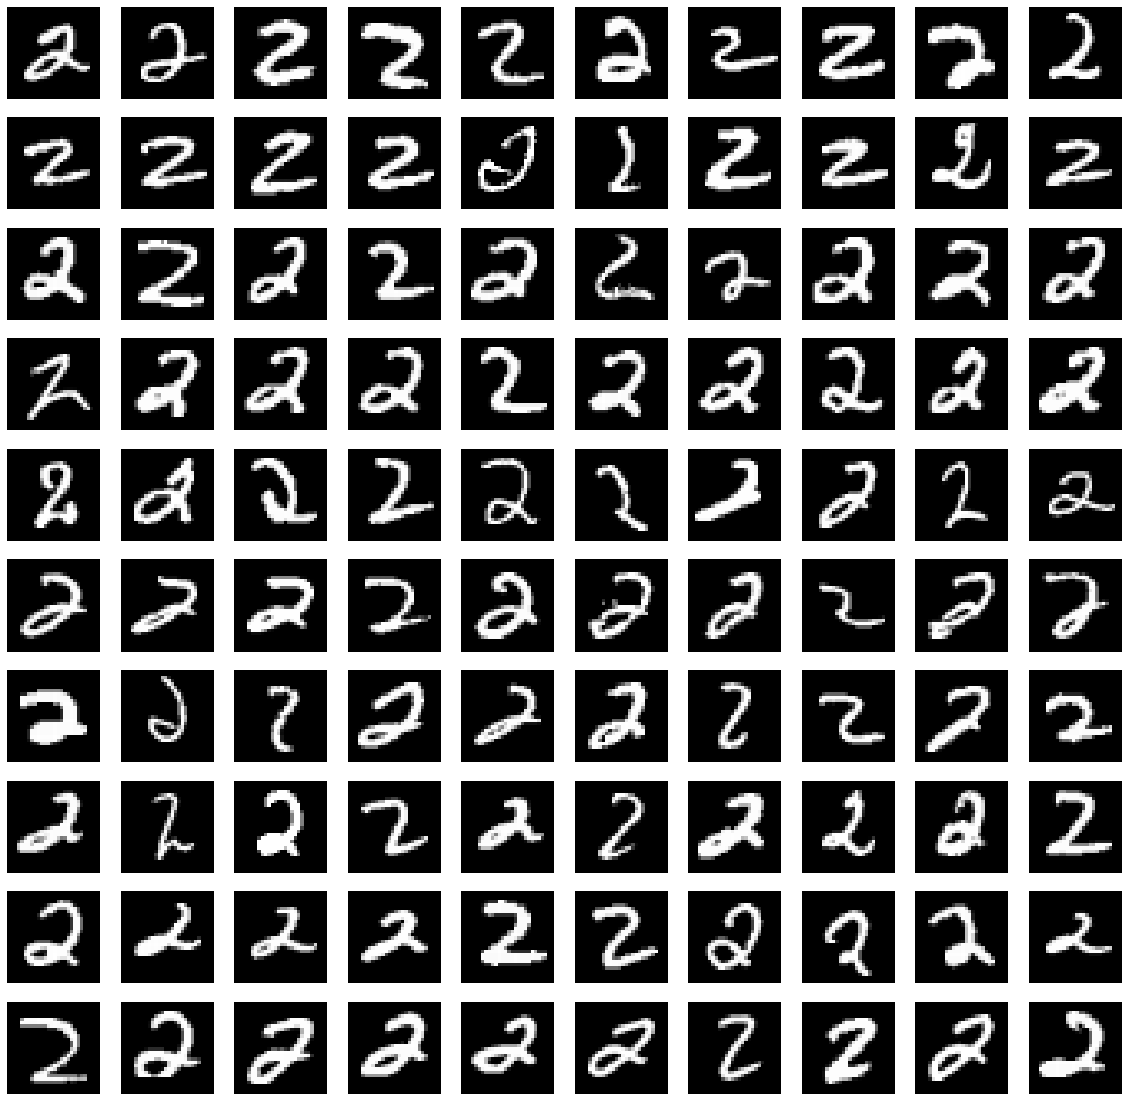

In [70]:
num_cols = 10
num_rows = 10 # num_samples // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, axs_ in enumerate(axs):
    for j, ax in enumerate(axs_):
        ax.imshow(X1[10 * i + j].reshape(28, 28), cmap="gray")
        ax.set_axis_off()
        
plt.show()

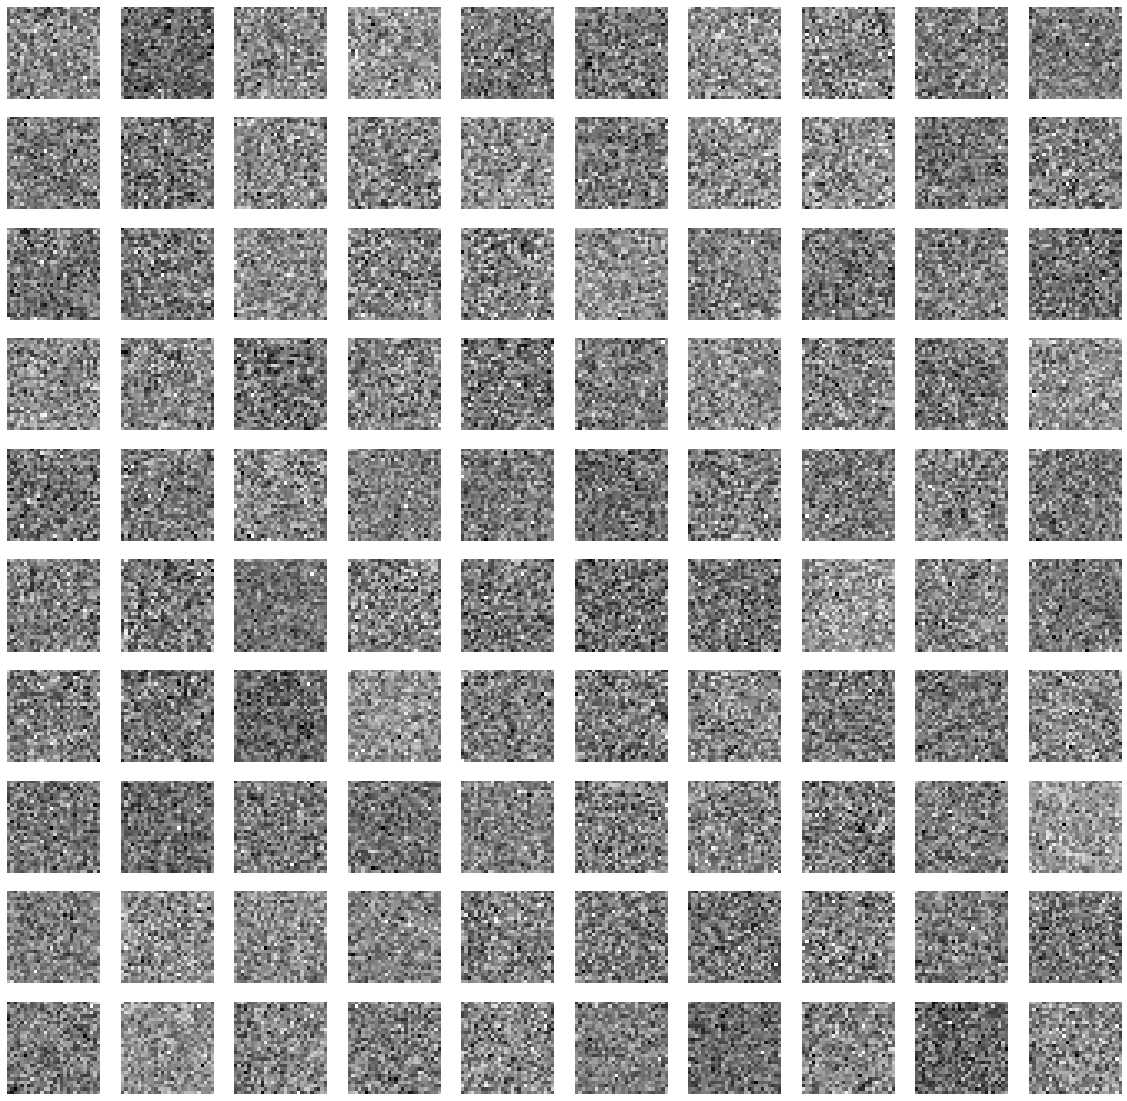

In [71]:
num_cols = 10
num_rows = 10 # num_samples // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, axs_ in enumerate(axs):
    for j, ax in enumerate(axs_):
        ax.imshow(X0[10 * i + j].reshape(28, 28), cmap="gray")
        ax.set_axis_off()
        
plt.show()

In [85]:
noise_reshaped = noise.reshape(num_samples, 1, 28, 28)
digits_reshaped = digits.reshape(num_samples, 1, 28, 28)

In [86]:
unet = UNet(enc_chs=(1, 128, 256), dec_chs=(256, 128), retain_dim=True).cuda()
params_to_optimize = unet.parameters()

In [27]:
# Randomly initalise layers with kaiming_normal initialisation

def weights_init(m):
    # We don't even need the isinstance check; they're all conv layers
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias.data)
    
unet.apply(weights_init)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    )
    (dec_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      )
    )
  )
  (head): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [45]:
# Freeze all params except last layer
for name, param in unet.named_parameters():
    if name[:5] != "head.":
        param.requires_grad = False
        
# To be sure, only give the optimizer these weights        
params_to_optimize = (unet.head.weight, unet.head.bias)

In [87]:
criterion = nn.MSELoss()
optimizer = optim.Adam(params_to_optimize, lr=0.001)

In [88]:
criterion(noise_reshaped, digits_reshaped)

tensor(0.2109, device='cuda:0')

In [89]:
criterion(unet(noise_reshaped), digits_reshaped)
criterion(unet(digits_reshaped), noise_reshaped)

tensor(0.1197, device='cuda:0', grad_fn=<MseLossBackward0>)

In [90]:
ds = TensorDataset(digits_reshaped, noise_reshaped)
ds = TensorDataset(noise_reshaped, digits_reshaped)
dl = DataLoader(ds, batch_size=40, shuffle=False)

In [91]:
num_epochs = 1000

losses = []
for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dl):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = unet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    current_loss = loss.item()
    losses.append(current_loss)
print('Finished Training')

100%|██████████| 1000/1000 [04:55<00:00,  3.38it/s]

Finished Training


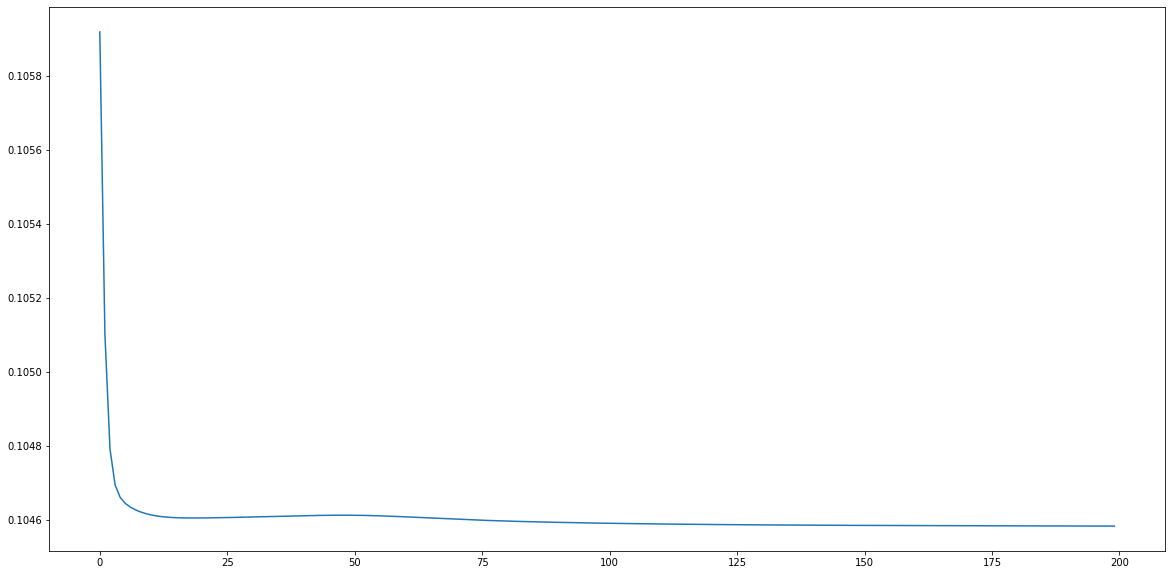

In [54]:
# Training only last layer
plt.figure(figsize=(20, 10))
plt.plot(list(range(len(losses))), losses)

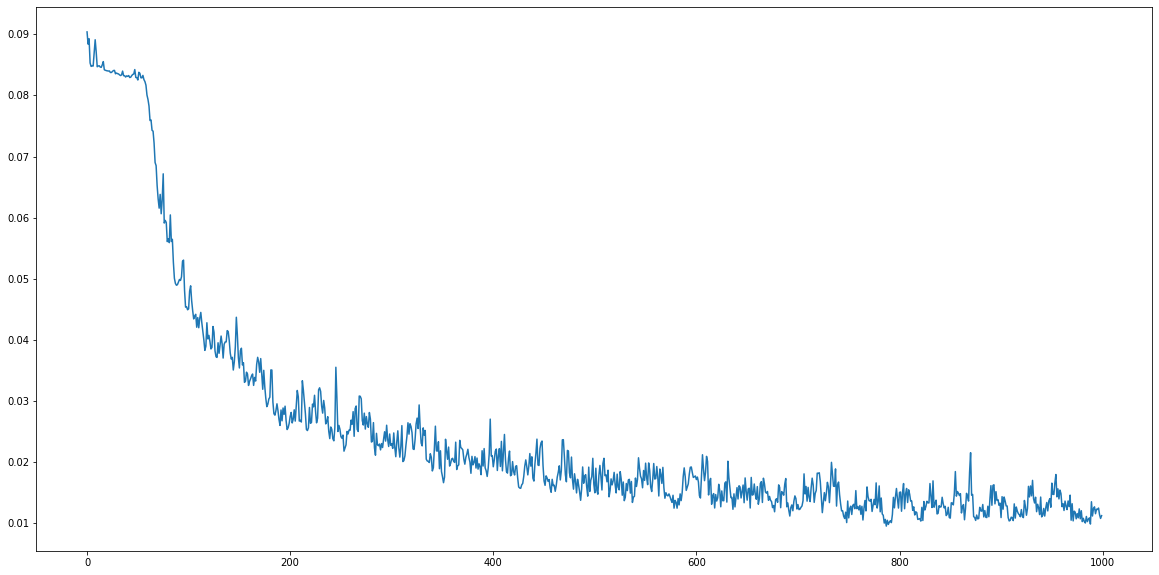

In [45]:
# Training all layers
plt.figure(figsize=(20, 10))
plt.plot(list(range(len(losses))), losses)

### Noise -> digits (constrained)

In [41]:
preds = unet(noise_reshaped)
print(criterion(preds, digits_reshaped))
print(preds.shape)

tensor(0.0879, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([1000, 1, 28, 28])


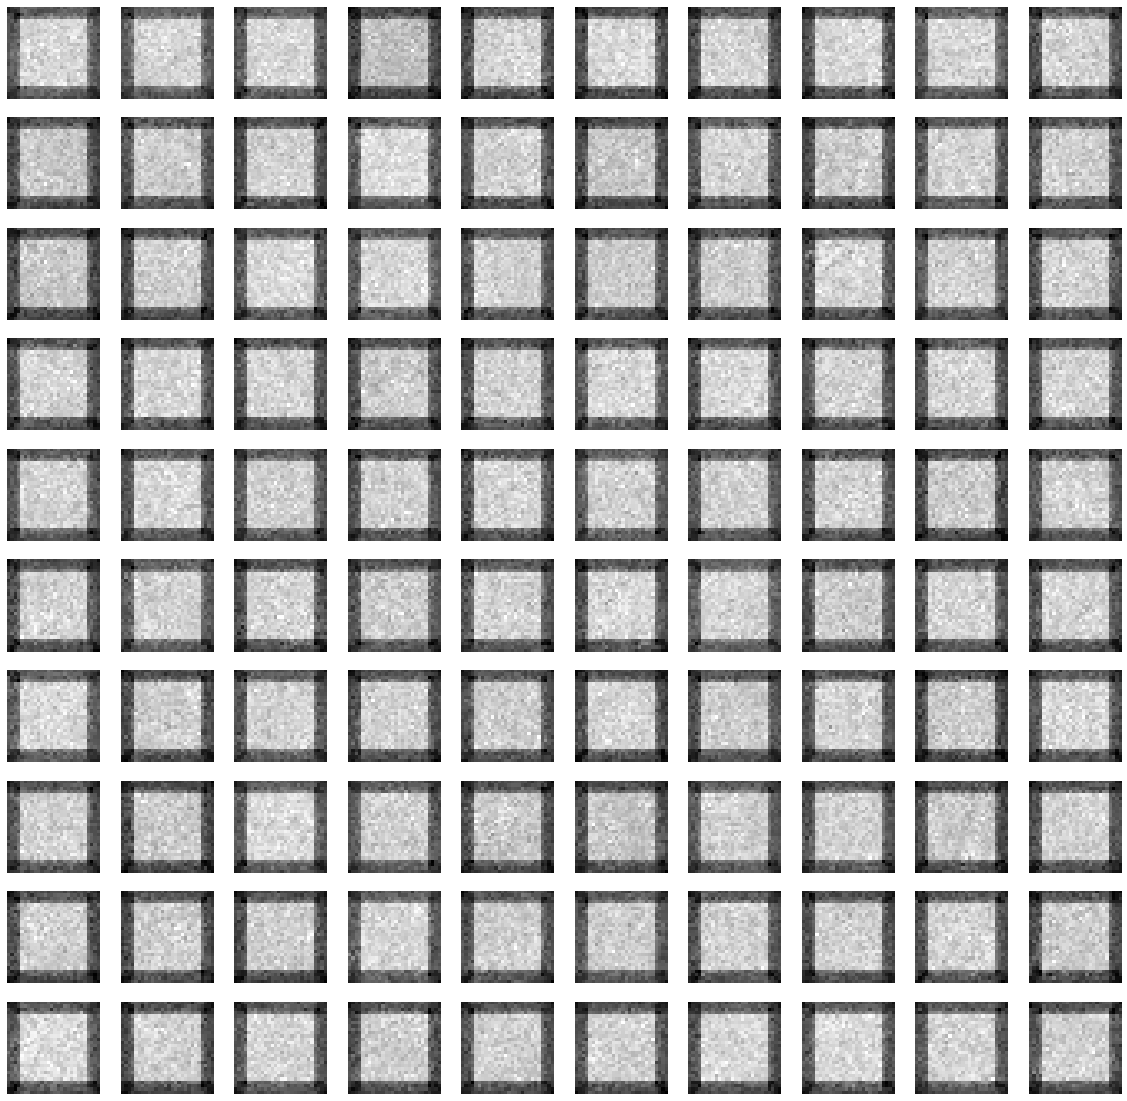

In [42]:
# After 100 epochs, last layer only model
num_cols = 10
num_rows = 10 # num_samples // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, axs_ in enumerate(axs):
    for j, ax in enumerate(axs_):
        ax.imshow(preds[10 * i + j].detach().cpu().numpy()[0], cmap="gray")
        ax.set_axis_off()
        
plt.show()

### Digits -> noise (constrained)

In [55]:
preds = unet(digits_reshaped)
print(criterion(preds, noise_reshaped))
print(preds.shape)

tensor(0.1055, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([1000, 1, 28, 28])


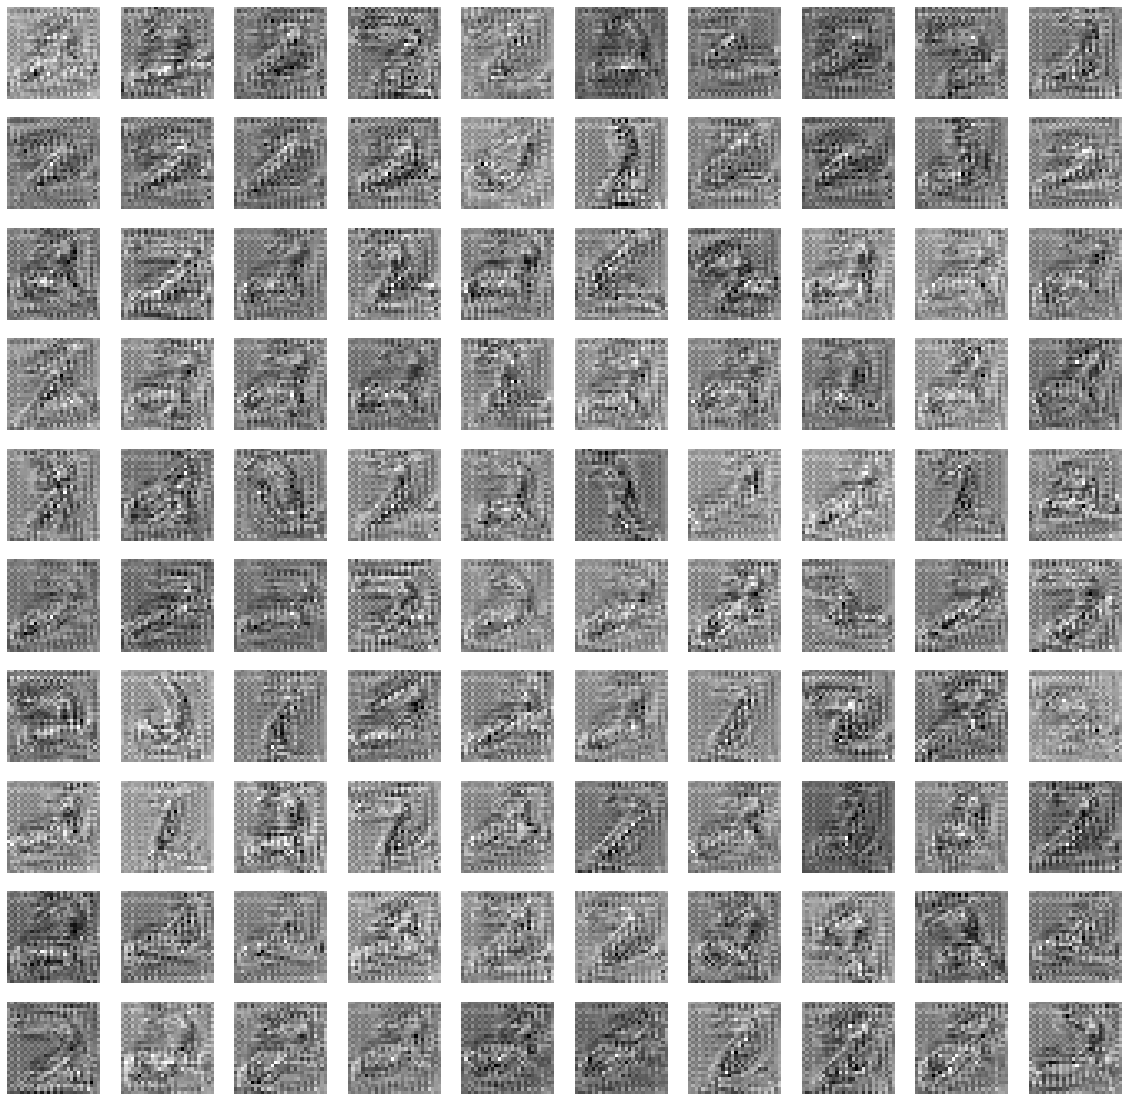

In [53]:
# After 1000 epochs, unconstrained model
num_cols = 10
num_rows = 10 # num_samples // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, axs_ in enumerate(axs):
    for j, ax in enumerate(axs_):
        ax.imshow(preds[10 * i + j].detach().cpu().numpy()[0], cmap="gray")
        ax.set_axis_off()
        
plt.show()

### Noise -> digits (unconstrained)

In [93]:
# After 1000 epochs
preds = unet(noise_reshaped)
print(criterion(preds, digits_reshaped))
print(preds.shape)

tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([1000, 1, 28, 28])


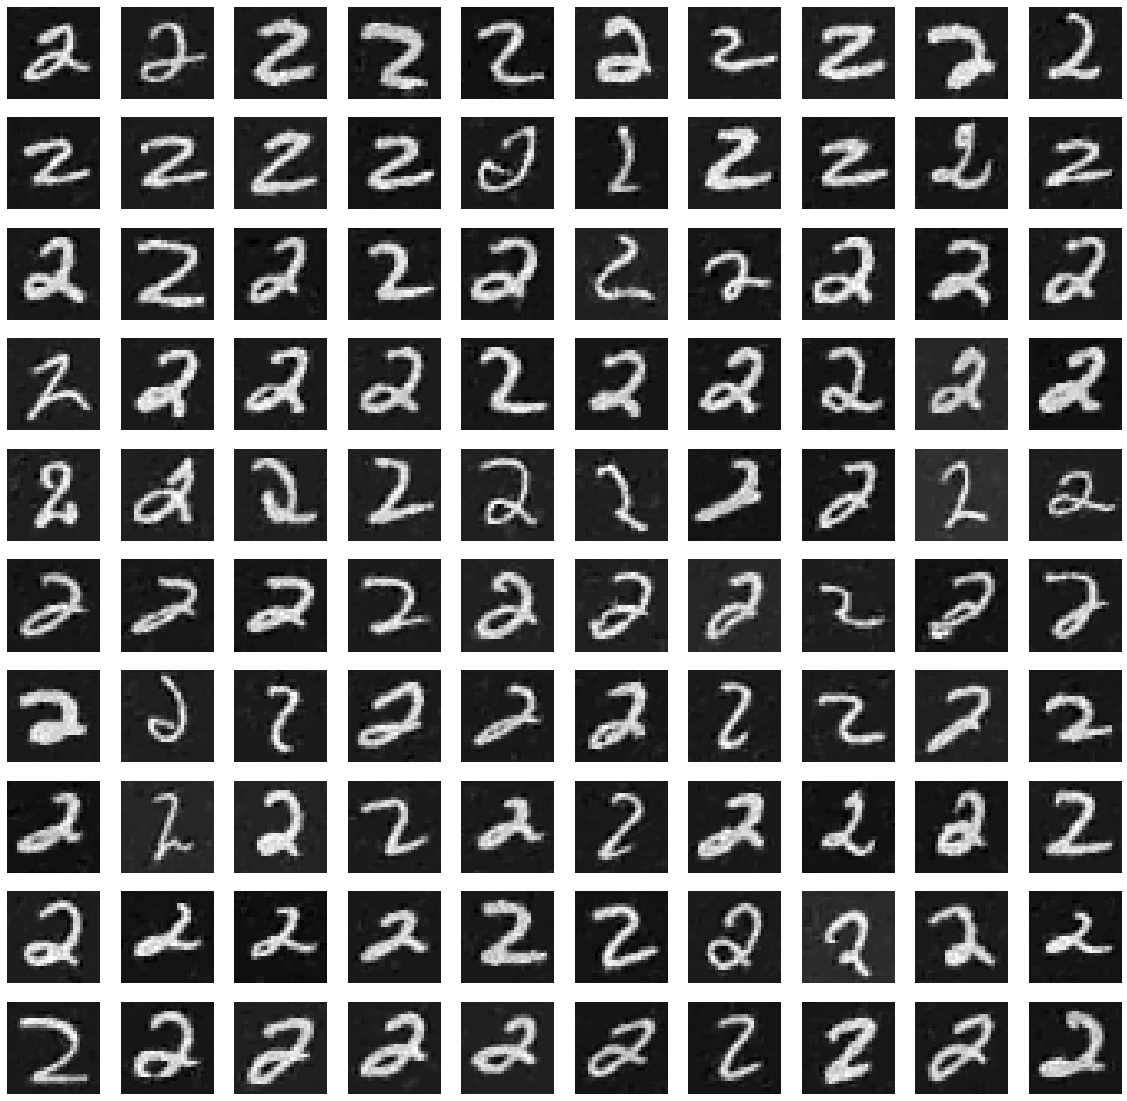

In [94]:
# After 1000 epochs
num_cols = 10
num_rows = 10 # num_samples // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, axs_ in enumerate(axs):
    for j, ax in enumerate(axs_):
        ax.imshow(preds[10 * i + j].detach().cpu().numpy()[0], cmap="gray")
        ax.set_axis_off()
        
plt.show()

### Try on new noise (unconstrained)

In [95]:
new_noise = torch.normal(X1.mean(), X1.std(), size=X1.shape).to(device)
new_noise_reshaped = new_noise.reshape(num_samples, 1, 28, 28)

In [96]:
preds_new = unet(new_noise_reshaped)
print(criterion(preds_new, digits_reshaped))
print(preds.shape)

tensor(0.1273, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([1000, 1, 28, 28])


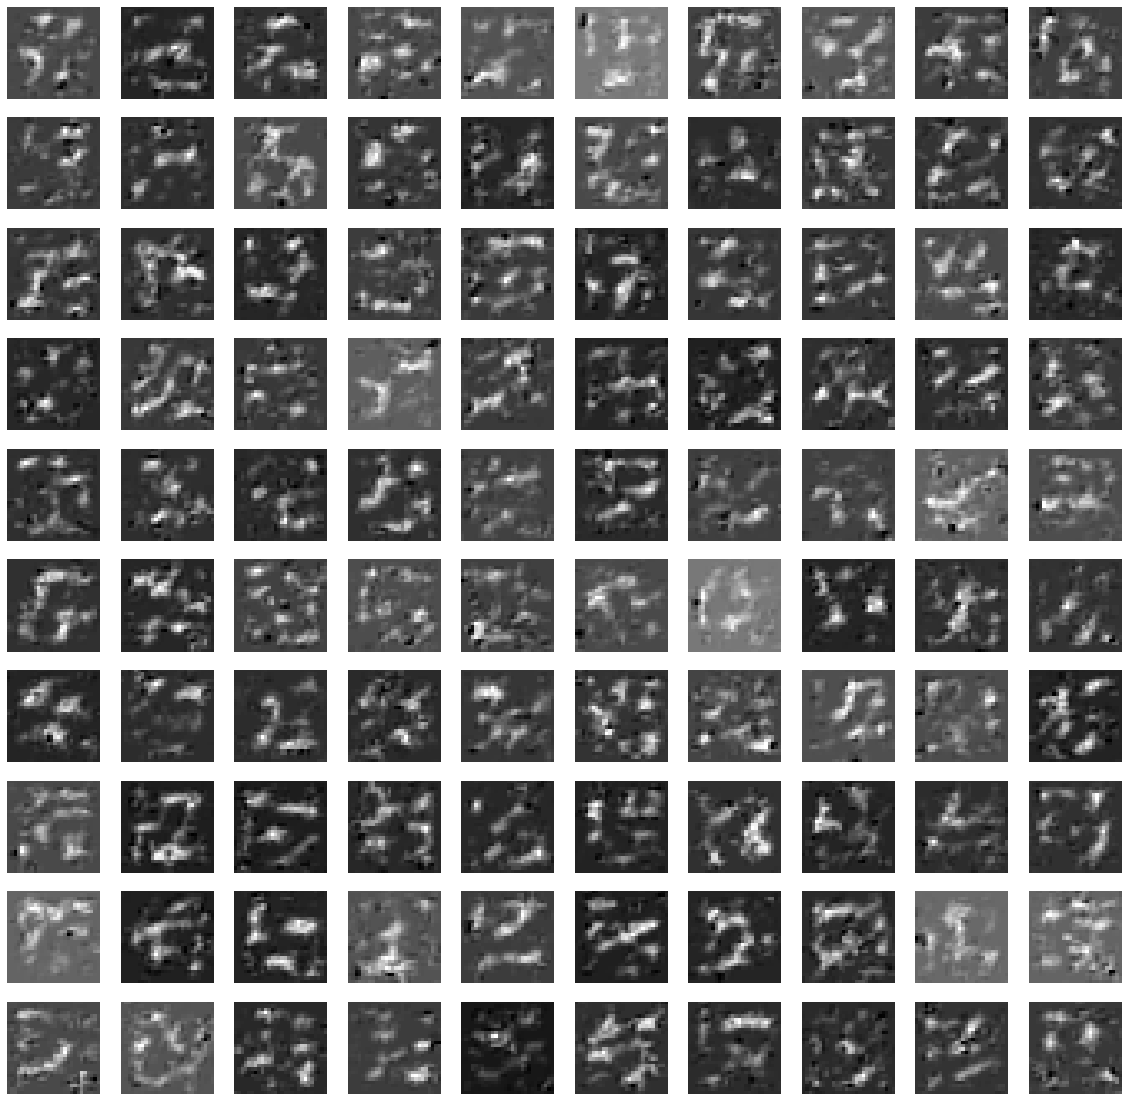

In [97]:
# After 1000 epochs, unconstrained model
num_cols = 10
num_rows = 10 # num_samples // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, axs_ in enumerate(axs):
    for j, ax in enumerate(axs_):
        ax.imshow(preds_new[10 * i + j].detach().cpu().numpy()[0], cmap="gray")
        ax.set_axis_off()
        
plt.show()

### Digits -> noise (unconstrained)

In [77]:
preds = unet(digits_reshaped)
print(criterion(preds, noise_reshaped))
print(preds.shape)

tensor(0.0466, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([1000, 1, 28, 28])


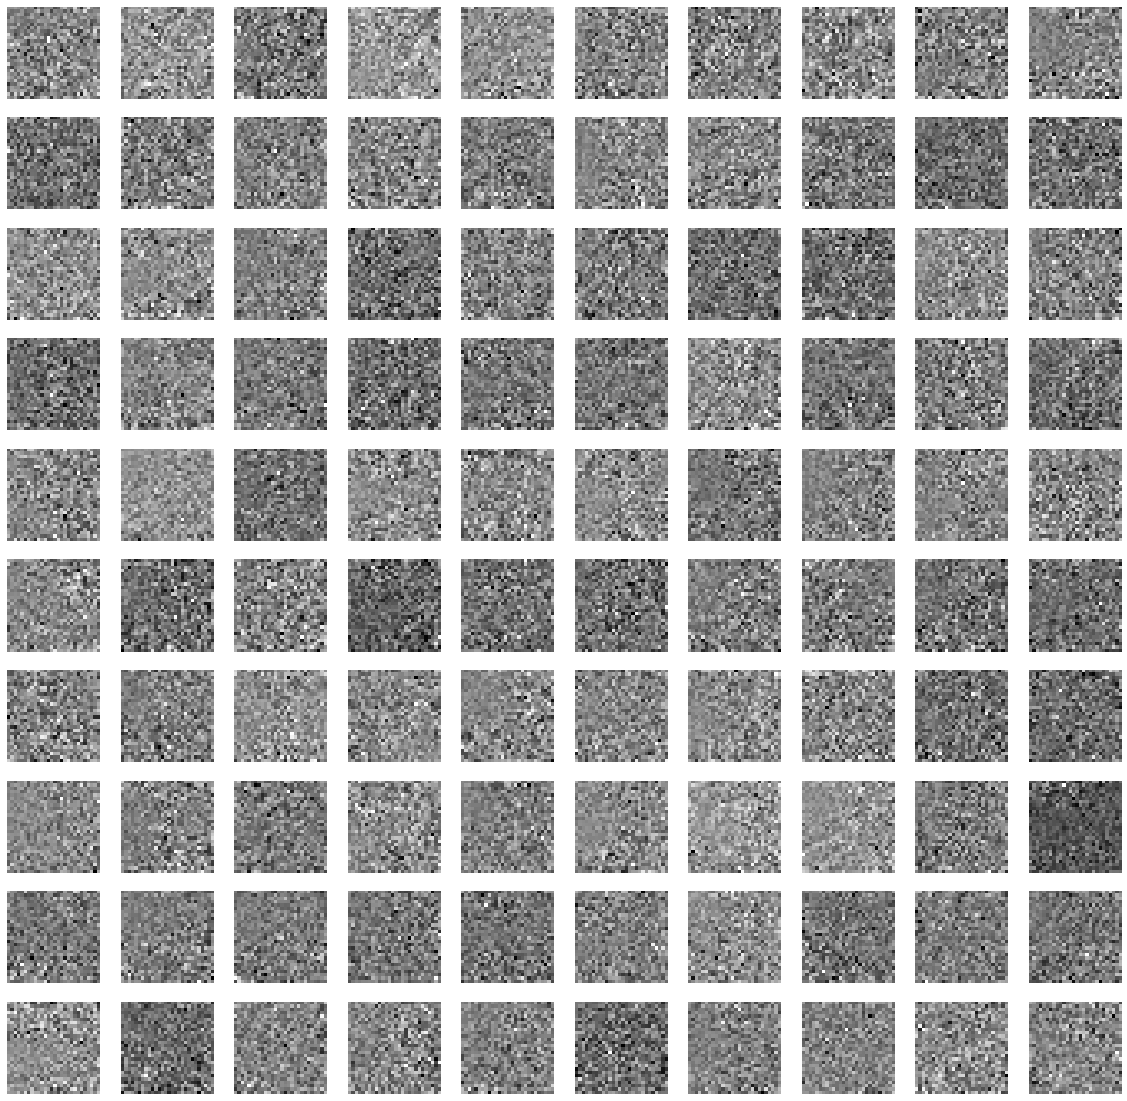

In [78]:
# After 1000 epochs, unconstrained model
num_cols = 10
num_rows = 10 # num_samples // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, axs_ in enumerate(axs):
    for j, ax in enumerate(axs_):
        ax.imshow(preds[10 * i + j].detach().cpu().numpy()[0], cmap="gray")
        ax.set_axis_off()
        
plt.show()

### Original version: "cleaner", but more blocky
With a single upconv layer instead of two.

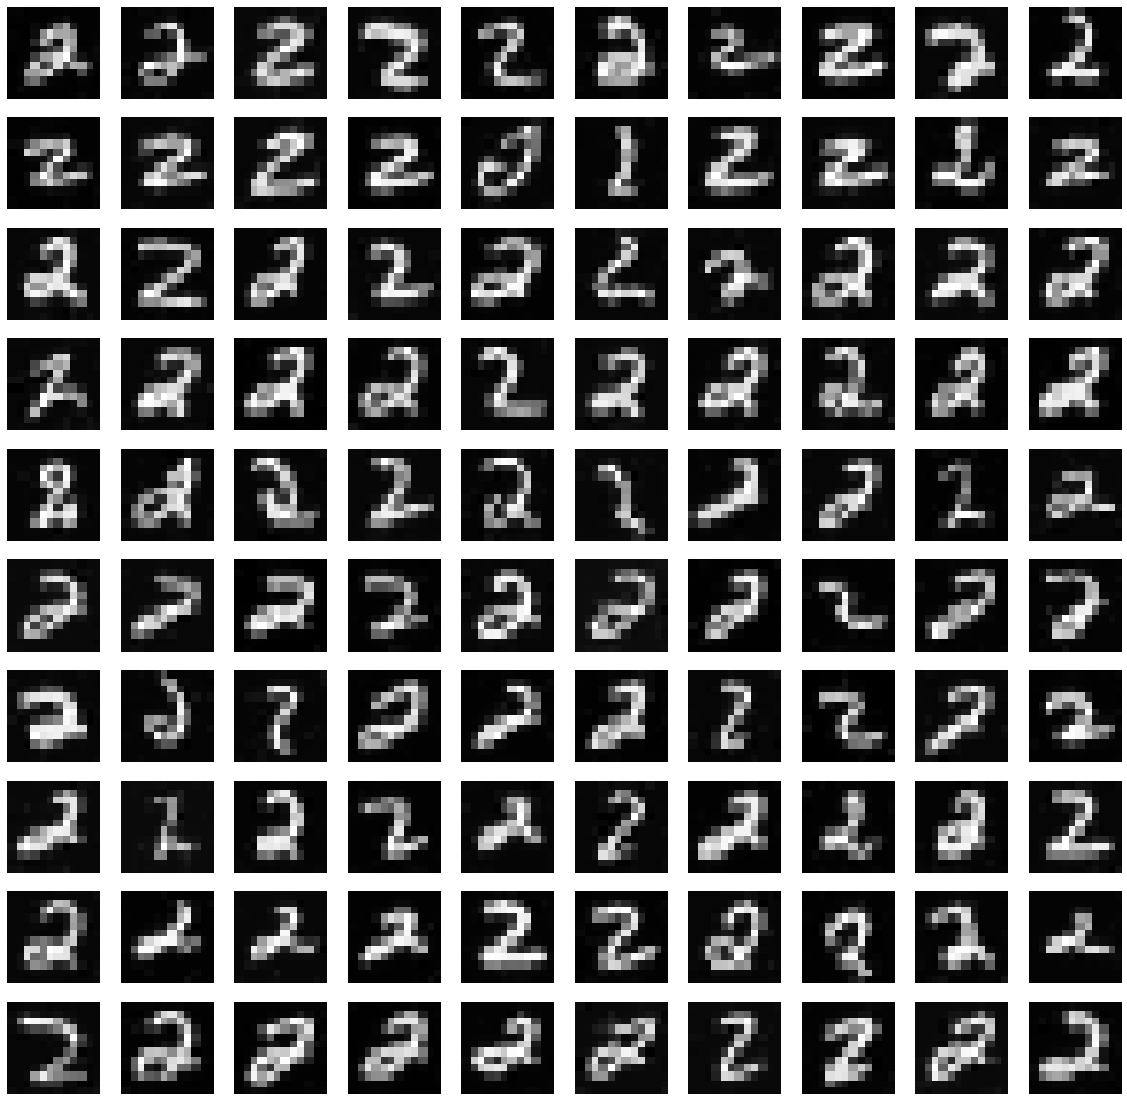

In [17]:
# After 1000 epochs, old model with single upconv
num_cols = 10
num_rows = 10 # num_samples // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, axs_ in enumerate(axs):
    for j, ax in enumerate(axs_):
        ax.imshow(preds[10 * i + j].detach().cpu().numpy()[0], cmap="gray")
        ax.set_axis_off()
        
plt.show()

### Inspect and play around with the model

In [56]:
# A version where we use a different upconv layer --> more params

class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64), verbose=False):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[0], chs[1], 2, 2) for _ in range(len(chs))])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        self.verbose = verbose
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            if self.verbose: print(f"dec1: {x.shape}")
                
            x        = self.upconvs[i](x)
            if self.verbose: print(f"dec2: {x.shape}")
            
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            if self.verbose: print(f"dec3: {x.shape}")            
            
            x        = self.upconvs[i+1](x)  # Used a different upconv layer
            if self.verbose: print(f"dec4: {x.shape}")            
            
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            if self.verbose: print(f"dec45: {x.shape}")            

            
            x        = self.dec_blocks[i](x)
            if self.verbose: print(f"dec5: {x.shape}")                   
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


In [57]:
model = UNet(enc_chs=(1, 64, 128), dec_chs=(128, 64), retain_dim=True, verbose=True).cuda()

In [58]:
for name, param in model.named_parameters():
    if name[:5] != "head.":
        param.requires_grad = False

In [59]:
pred = model(noise_reshaped)

f1: torch.Size([1000, 1, 28, 28])
enc1: torch.Size([1000, 1, 28, 28])
enc2: torch.Size([1000, 64, 24, 24])
enc3: torch.Size([1000, 64, 12, 12])
enc1: torch.Size([1000, 64, 12, 12])
enc2: torch.Size([1000, 128, 8, 8])
enc3: torch.Size([1000, 128, 4, 4])
f2: torch.Size([1000, 128, 8, 8])
dec1: torch.Size([1000, 128, 8, 8])
dec2: torch.Size([1000, 64, 16, 16])
dec3: torch.Size([1000, 128, 16, 16])
dec4: torch.Size([1000, 64, 32, 32])
dec45: torch.Size([1000, 128, 32, 32])
dec5: torch.Size([1000, 64, 28, 28])
f3: torch.Size([1000, 64, 28, 28])
f4: torch.Size([1000, 1, 28, 28])
f5: torch.Size([1000, 1, 28, 28])


In [60]:
model

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
      (1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    )
    (dec_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
  )
  (head): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1

In [63]:
from prettytable import PrettyTable

In [66]:
t = PrettyTable(['Layer', 'Weight shape', "# Params", "requires_grad"])
for i in model.named_parameters():
    t.add_row([i[0], i[1].shape, i[1].numel(), i[1].requires_grad])
    
t.align["Weight shape"] = "l"    
t.align["# Params"] = "r"

print(t)

+-----------------------------------+------------------------------+----------+---------------+
|               Layer               | Weight shape                 | # Params | requires_grad |
+-----------------------------------+------------------------------+----------+---------------+
| encoder.enc_blocks.0.conv1.weight | torch.Size([64, 1, 3, 3])    |      576 |     False     |
|  encoder.enc_blocks.0.conv1.bias  | torch.Size([64])             |       64 |     False     |
| encoder.enc_blocks.0.conv2.weight | torch.Size([64, 64, 3, 3])   |    36864 |     False     |
|  encoder.enc_blocks.0.conv2.bias  | torch.Size([64])             |       64 |     False     |
| encoder.enc_blocks.1.conv1.weight | torch.Size([128, 64, 3, 3])  |    73728 |     False     |
|  encoder.enc_blocks.1.conv1.bias  | torch.Size([128])            |      128 |     False     |
| encoder.enc_blocks.1.conv2.weight | torch.Size([128, 128, 3, 3]) |   147456 |     False     |
|  encoder.enc_blocks.1.conv2.bias  | to

In [48]:
def weights_init(m):
    # We don't even need the isinstance check; they're all conv layers
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias.data)
    
model.apply(weights_init)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
      (1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    )
    (dec_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
  )
  (head): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1

In [60]:
def display_activations(module, input, output):
    print(output.shape)
    num_cols = 8
    num_rows = output.shape[1] // num_cols

    plt.figure(figsize = (8,16))
    for i, w in enumerate(output.squeeze()):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(w.detach().numpy())
        plt.axis('off') 

def print_output_shape_hook(module, input, output):
    print(f"{module.__repr__()[:5]} : {output.shape}")

# model = copy.deepcopy(unet)
# model.encoder.enc_blocks[0].conv1.register_forward_hook(print_output_shape_hook)